# 统计学习导论第十次作业
神经网络实现无监督神经网络：  
sklearn提供的算法：受限玻尔兹曼机（RBM），通过对比有无进行聚类再进行Logistic回归、多维缩放MDS评价RBM的效果  
MiniSom库提供的SOM模型

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据探索与预处理
##### 数据来源
sklearn库直接导入手写数字数据，但数据量只有1797，对数据实现扩展放大五倍
##### 主题
神经网络实现无监督学习
### 1.1 数据导入与探索

输入数据形状 (1797, 64)
输出数据形状 (1797,)


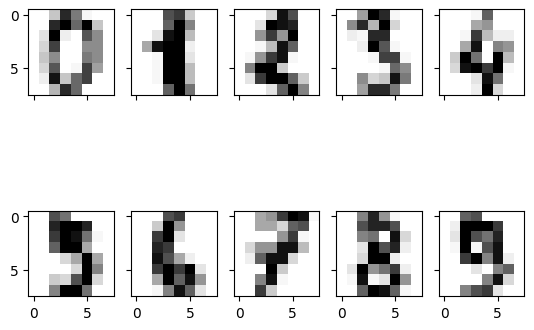

In [6]:
####--------------------------------统计学习导论第十一次作业——RBM模型（神经网络实现无监督学习）--------------------------------####
## Restricted Boltzmann Machine
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import convolve

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split


# --------------------------------1、数据探索与预处理--------------------------------#

## 导入sklearn自带的手写数字数据集
digits = load_digits()
print('输入数据形状', digits.data.shape)
print('输出数据形状', digits.target.shape)

# 获取输入数据和输出数据
X = digits.data
y = digits.target
 
#  展示前十个数据的图像看看
fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(digits.data[i].reshape((8, 8)), cmap='Greys', interpolation='nearest')
plt.savefig(fname="手写数字数据前十个示例数据.png")

### 1.2 数据扩展
原始数据只有1797个，数据量太小不够训练   
按照sklearn给的数据扩展方法：通过每个方向1个像素的线性偏移来扰训练数据，人为地生成更多的标记数据。  
即通过将X中的8x8图像向左、右、下、上移动1个像素，产生一个比原始数据大5倍的数据集。  

In [7]:
def nudge_dataset(X, Y):
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

X, Y = nudge_dataset(X, y)

print('输入数据形状', X.shape)
print('输出数据形状', Y.shape)

输入数据形状 (8985, 64)
输出数据形状 (8985,)


### 1.3 归一化
考虑最大最小归一化和Z-score标准化

In [8]:
## 归一化
# 考虑最大最小归一化、zsocre标准化

# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X_standard = standard_scaler.fit_transform(X)

### 1.4 数据划分
划分80%的训练集和20%的测试集

In [9]:
## 数据划分
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## 二、模型建立与参数优化

### 2.1 模型建立
先用RBM实现无监督学习提取特征，再使用Logistic回归基于上述特征实现分类

In [10]:
# --------------------------------2、模型建立与参数优化--------------------------------#
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

# 先用RBM实现无监督学习提取特征，再使用Logistic回归基于上述特征实现分类
rbm = BernoulliRBM(random_state=0, verbose=True)
logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

### 2.2 预调参
使用网格搜索先进行预调参，缩小最佳参数的范围

In [11]:
## 粗调参
# 网格搜索最佳参数
param_grid = {
    "rbm__learning_rate": [0.001, 0.01, 0.1, 1],
    "rbm__n_iter": [5, 10, 15, 20],
    "rbm__n_components": [50, 100, 150],
    "logistic__C": [1000, 5000, 10000]
}

grid_search = GridSearchCV(rbm_features_classifier, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -31.71, time = 0.05s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -30.03, time = 0.12s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -29.51, time = 0.07s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -29.29, time = 0.06s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -29.17, time = 0.09s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -31.74, time = 0.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -30.06, time = 0.07s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -29.53, time = 0.10s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -29.31, time = 0.08s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -29.18, time = 0.10s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -31.75, time = 0.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -30.07, time = 0.07s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -29.56, time = 0.07s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -29.33, time = 0.06s
[BernoulliRBM] Iteration 5, pseudo

### 2.3 调参
再次使用网格搜索，在粗调参附近寻找最佳参数

In [12]:
# 网格搜索最佳参数
param_grid = {
    "rbm__learning_rate": [0.06, 0.08, 0.1],
    "rbm__n_iter": [10],
    "rbm__n_components": [150],
    "logistic__C": [6000, 8000, 10000]
}

grid_search = GridSearchCV(rbm_features_classifier, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -26.36, time = 0.07s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.84, time = 0.32s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.41, time = 0.24s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.81, time = 0.29s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -22.34, time = 0.20s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -22.01, time = 0.20s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -21.77, time = 0.13s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -21.30, time = 0.19s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.96, time = 0.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.74, time = 0.12s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -26.22, time = 0.09s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.54, time = 0.14s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.51, time = 0.14s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.88, time = 0.18s
[BernoulliRBM] Iteration 5, pseud

### 2.4 模型训练
使用最佳参数训练模型

In [13]:
rbm.learning_rate = 0.06
rbm.n_iter = 10
rbm.n_components = 150
logistic.C = 10000

rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.89, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.36, time = 0.19s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.01, time = 0.24s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.25, time = 0.17s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.84, time = 0.20s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.23, time = 0.18s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.71, time = 0.17s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.62, time = 0.20s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.22, time = 0.15s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.32, time = 0.16s


Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.06, n_components=150,
                              random_state=0, verbose=True)),
                ('logistic',
                 LogisticRegression(C=10000, solver='newton-cg', tol=1))])

### 2.5 训练对比模型
克隆一下之前的Logistic模型，为后续RBM-Logistic模型对比Logistic模型有提升效果

In [14]:
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, solver='newton-cg', tol=1)

## 三、模型评估
通过对比有事先RBM聚类再进行Logistic离散选择的效果与没有事先RBM聚类再进行Logistic离散选择的效果来评估模型
### 3.1 RBM-Logistic

##### 准确率Accuracy
正确分类的样本数占总样本数的比例
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$
##### 精确率precision
被分类器预测为正类的样本中，真正为正类的样本所占的比例
$$Precision = \frac{TP}{TP+FP}$$
##### 召回率recall
真正为正类的样本中，被分类器预测为正类的样本所占的比例
$$Recall = \frac{TP}{TP+FN}$$
##### F1值f1score
综合考虑精确率和召回率，精确率和召回率的调和平均数
$$F1 = \frac{2 Precision Recall}{Precision+Recall}$$

In [16]:
# --------------------------------4、模型评估--------------------------------#
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# 准确率Accuracy--正确分类的样本数占总样本数的比例
# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.92      0.97      0.94       184
           2       0.93      0.98      0.95       166
           3       0.97      0.91      0.94       194
           4       0.98      0.94      0.96       186
           5       0.93      0.94      0.93       181
           6       0.97      0.98      0.97       207
           7       0.95      0.99      0.97       154
           8       0.92      0.88      0.90       182
           9       0.92      0.93      0.92       169

    accuracy                           0.95      1797
   macro avg       0.95      0.95      0.95      1797
weighted avg       0.95      0.95      0.95      1797




##### 混淆矩阵

[[171   0   0   0   1   1   1   0   0   0]
 [  0 178   1   0   0   1   0   0   2   2]
 [  0   2 162   1   0   0   0   0   1   0]
 [  0   0   5 177   0   1   0   2   6   3]
 [  1   1   0   0 175   0   2   3   0   4]
 [  0   1   0   2   1 170   2   0   1   4]
 [  0   1   1   0   1   2 202   0   0   0]
 [  0   0   0   0   0   0   0 153   0   1]
 [  0  10   5   1   0   3   1   2 160   0]
 [  0   0   0   2   1   5   0   1   3 157]]


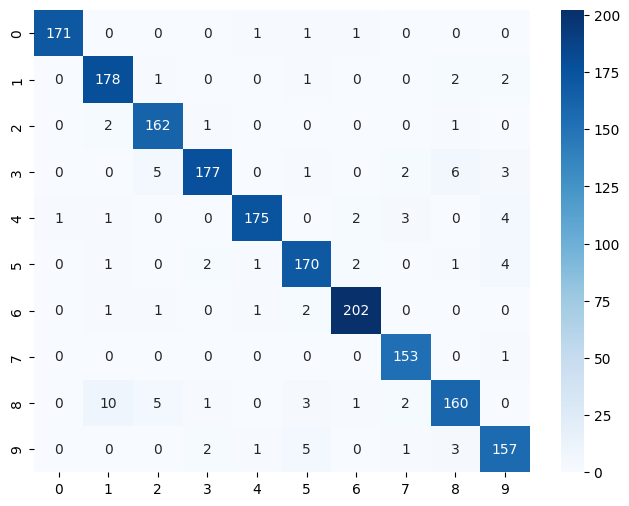

In [17]:
## 混淆矩阵
conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="RBM-Logistic 混淆矩阵.png")

##### ROC&AUC

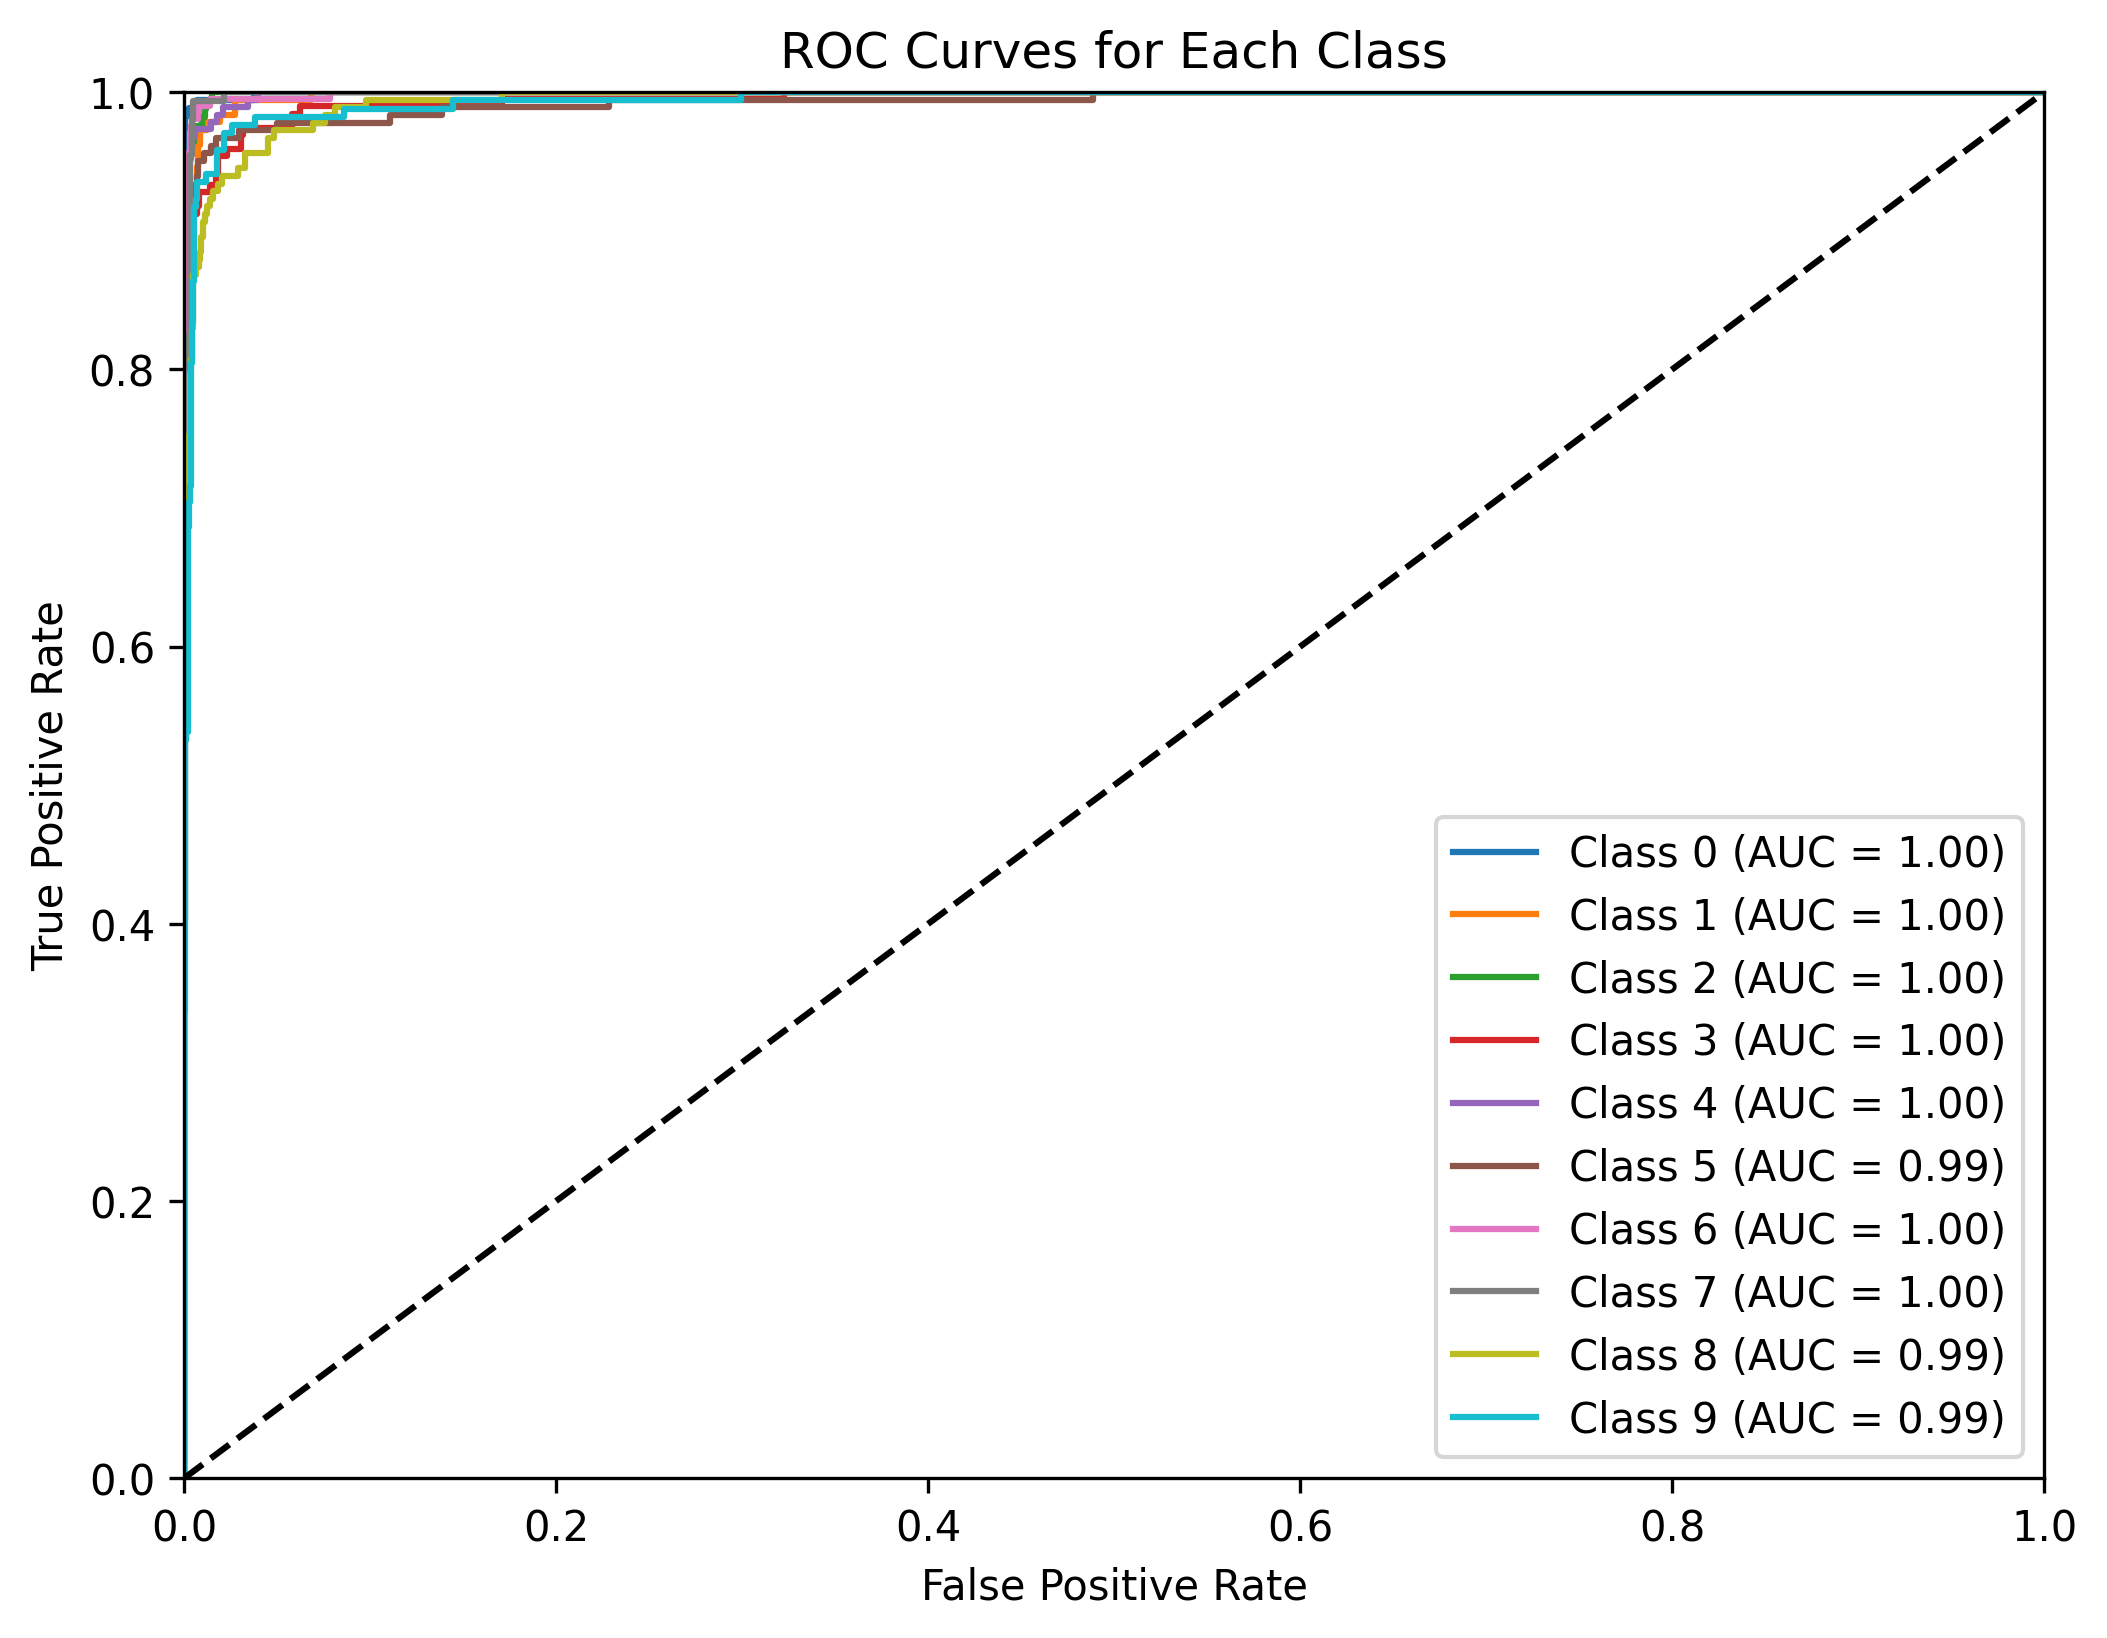

In [18]:
##  ROC曲线&AUC值
# 用于存储每个类别的FPR、TPR和AUC值
fprs = []
tprs = []
aucs = []

for i in range(10):
    y_test_binary = (Y_test == i).astype(int)
    y_pred_proba = rbm_features_classifier.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
    auc_value = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc_value)

plt.figure(figsize=(8, 6), dpi=300)
for i in range(10):
    plt.plot(fprs[i], tprs[i], label='Class {} (AUC = {:.2f})'.format(i, aucs[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.savefig(fname="RBM-Logistic ROC曲线.png")

### 3.2 Logistic
##### 准确率Accuracy
正确分类的样本数占总样本数的比例
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$
##### 精确率precision
被分类器预测为正类的样本中，真正为正类的样本所占的比例
$$Precision = \frac{TP}{TP+FP}$$
##### 召回率recall
真正为正类的样本中，被分类器预测为正类的样本所占的比例
$$Recall = \frac{TP}{TP+FN}$$
##### F1值f1score
综合考虑精确率和召回率，精确率和召回率的调和平均数
$$F1 = \frac{2 Precision Recall}{Precision+Recall}$$

In [19]:
# 准确率Accuracy--正确分类的样本数占总样本数的比例
# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
Y_pred_ = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (classification_report(Y_test, Y_pred_))
)


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       174
           1       0.60      0.59      0.60       184
           2       0.75      0.85      0.80       166
           3       0.78      0.78      0.78       194
           4       0.82      0.84      0.83       186
           5       0.77      0.76      0.76       181
           6       0.90      0.87      0.89       207
           7       0.86      0.88      0.87       154
           8       0.67      0.59      0.63       182
           9       0.75      0.76      0.75       169

    accuracy                           0.78      1797
   macro avg       0.78      0.78      0.78      1797
weighted avg       0.78      0.78      0.78      1797




##### 混淆矩阵

[[161   2   1   0   4   2   2   0   2   0]
 [  3 108  13  15  10   7   3   2  16   7]
 [  0   9 141   7   2   1   1   0   3   2]
 [  0   7   9 151   1   6   1   3   9   7]
 [  1   7   0   0 156   1   6   4   3   8]
 [  0   6  10   7   4 137   3   3   4   7]
 [  5   8   2   0   4   3 181   0   4   0]
 [  3   1   3   0   3   1   0 135   4   4]
 [  1  25   8   8   3  13   3   6 107   8]
 [  4   6   1   6   4   7   1   4   8 128]]


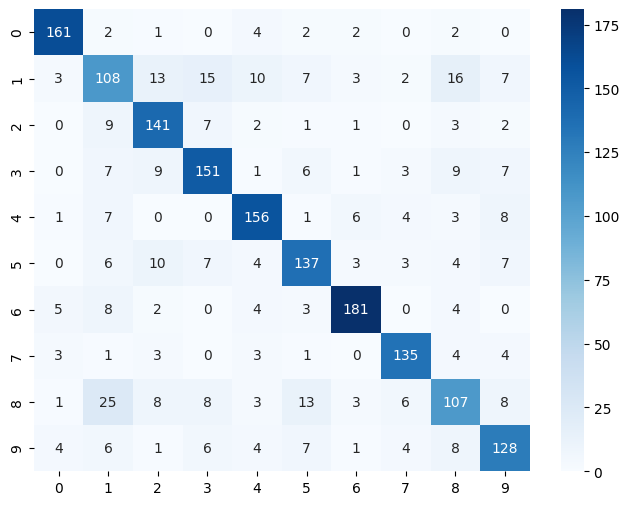

In [20]:
## 混淆矩阵
conf_matrix = confusion_matrix(Y_test, Y_pred_)
print(conf_matrix)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Logistic 混淆矩阵.png")

##### ROC&AUC

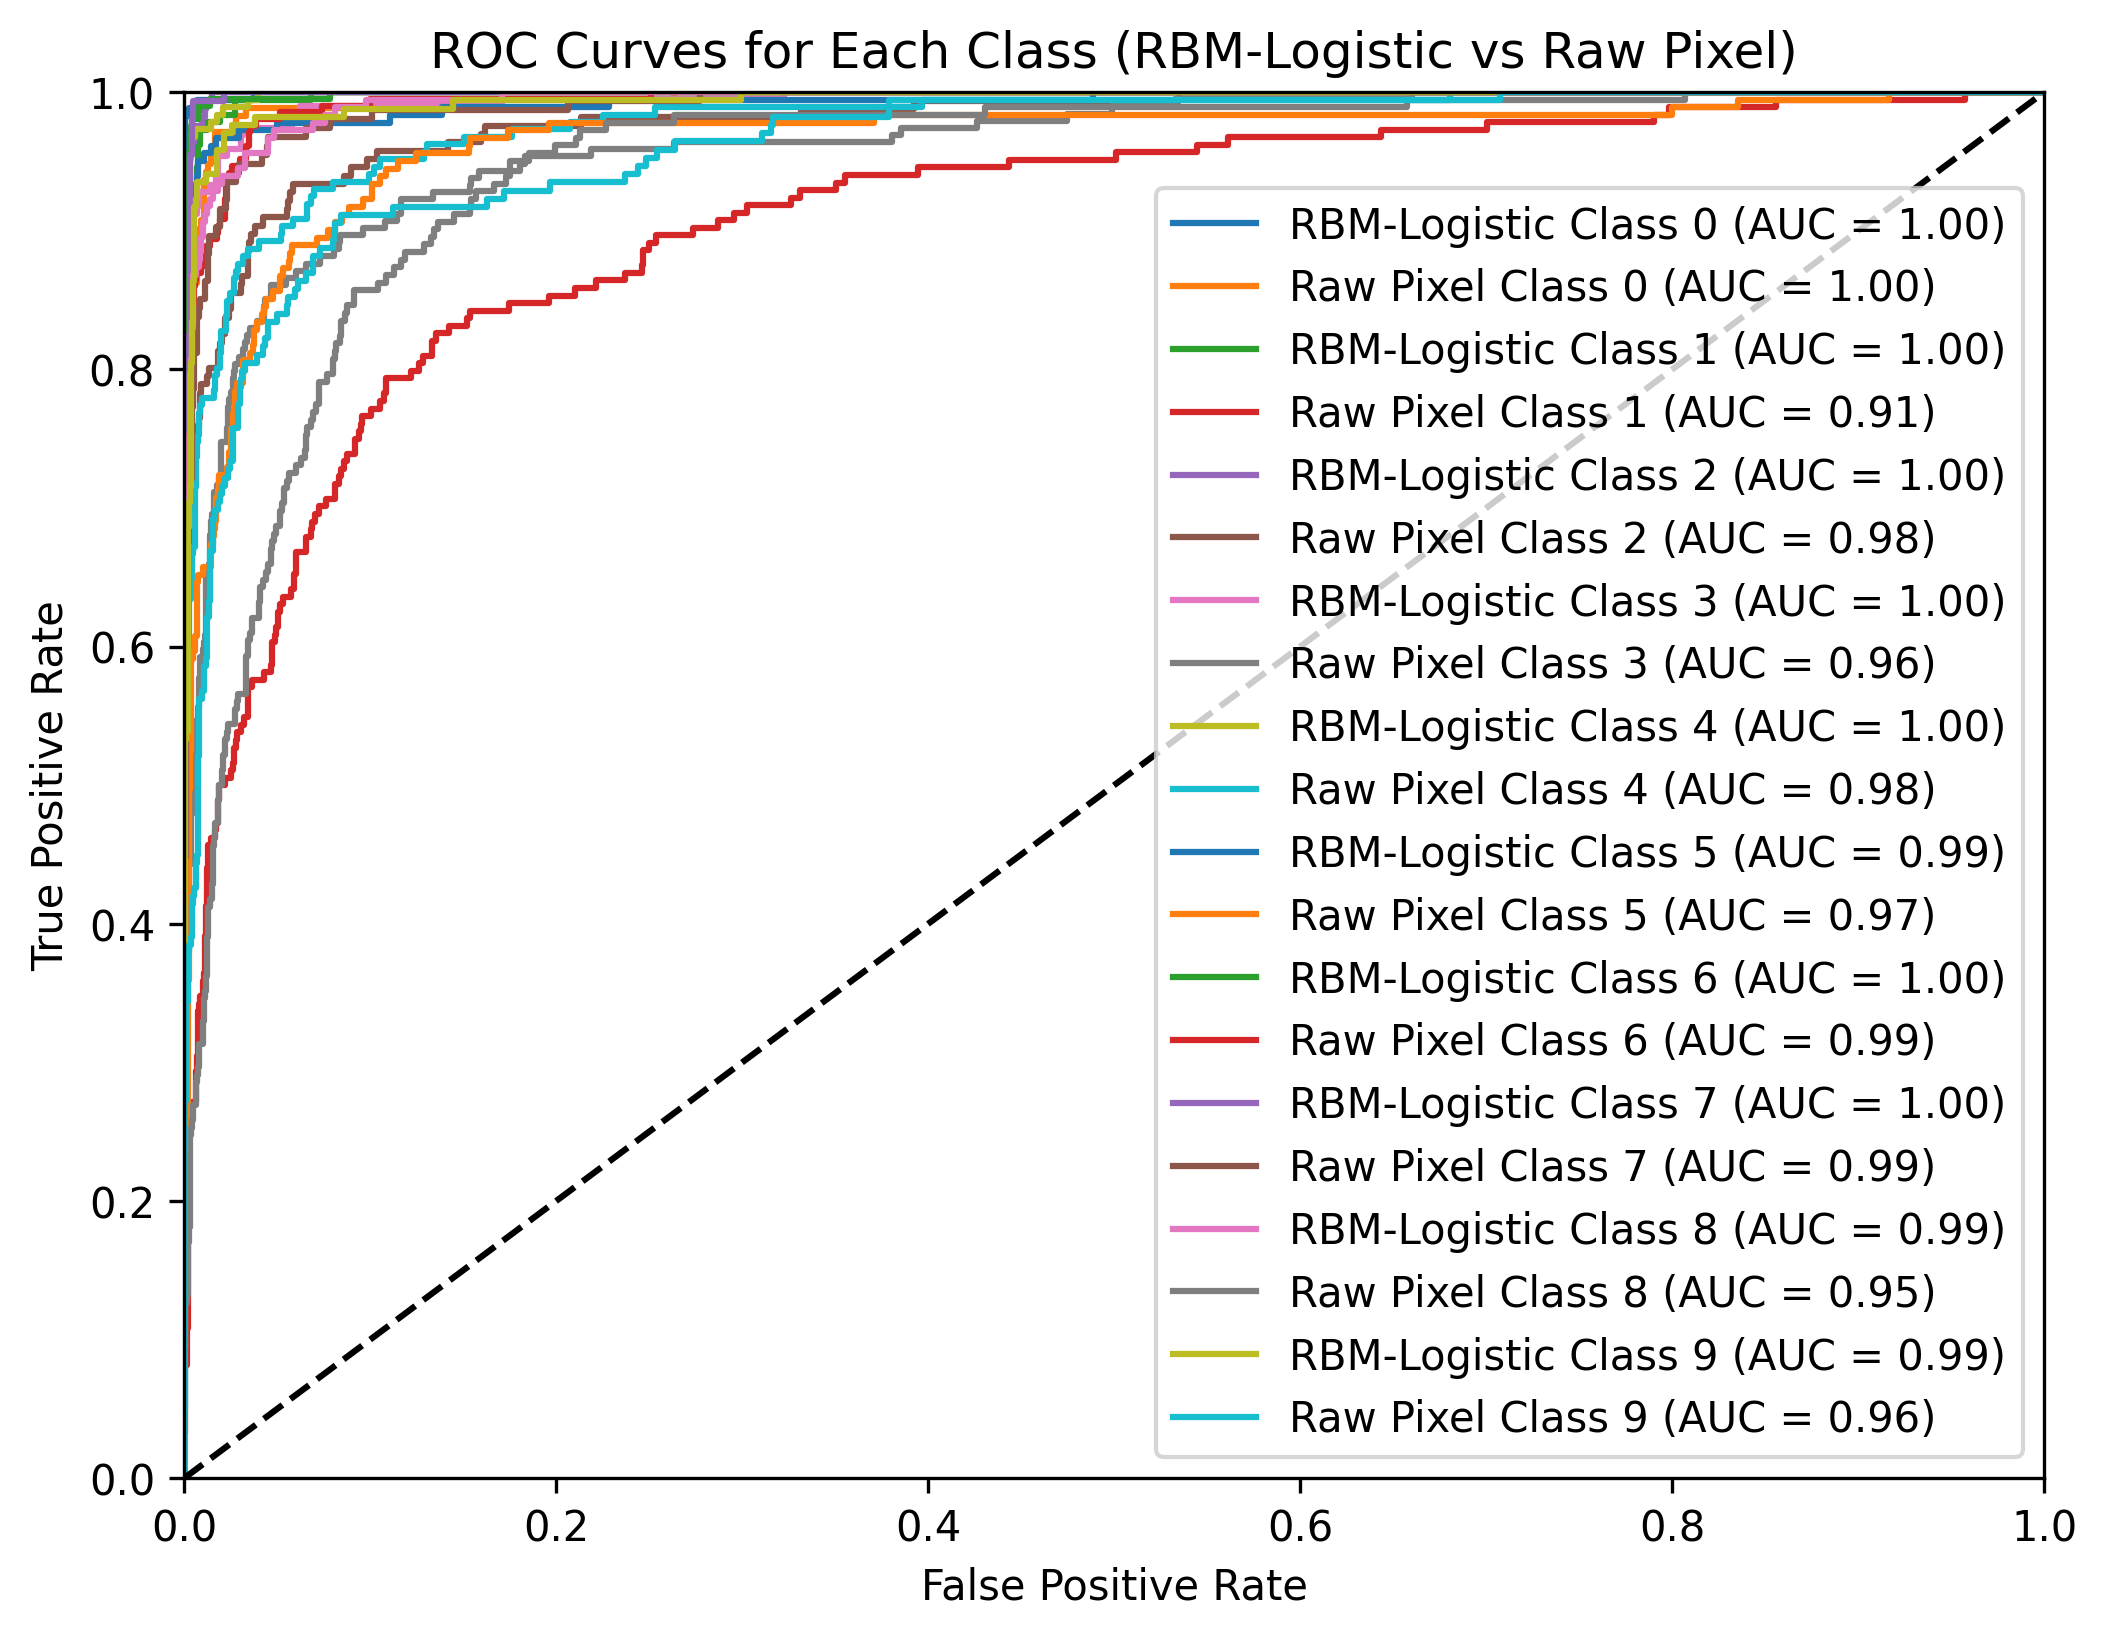

In [21]:
##  ROC曲线&AUC值
fprs_raw = []
tprs_raw = []
aucs_raw = []

for i in range(10):
    y_test_binary_raw = (Y_test == i).astype(int)
    y_pred_proba_raw = raw_pixel_classifier.predict_proba(X_test)[:, i]
    fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_binary_raw, y_pred_proba_raw)
    auc_value_raw = auc(fpr_raw, tpr_raw)
    fprs_raw.append(fpr_raw)
    tprs_raw.append(tpr_raw)
    aucs_raw.append(auc_value_raw)

plt.figure(figsize=(8, 6), dpi=300)
for i in range(10):
    plt.plot(fprs[i], tprs[i], label='RBM-Logistic Class {} (AUC = {:.2f})'.format(i, aucs[i]))
    plt.plot(fprs_raw[i], tprs_raw[i], label='Raw Pixel Class {} (AUC = {:.2f})'.format(i, aucs_raw[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (RBM-Logistic vs Raw Pixel)')
plt.legend(loc="lower right")
plt.savefig(fname="Logistic ROC曲线.png")

__结果表明：先使用RBM进行聚类的效果明显提升，但也有可能过拟合了:(__

## 四、模型结果可视化
#### 4.1 基于多维缩放MDS的结果可视化

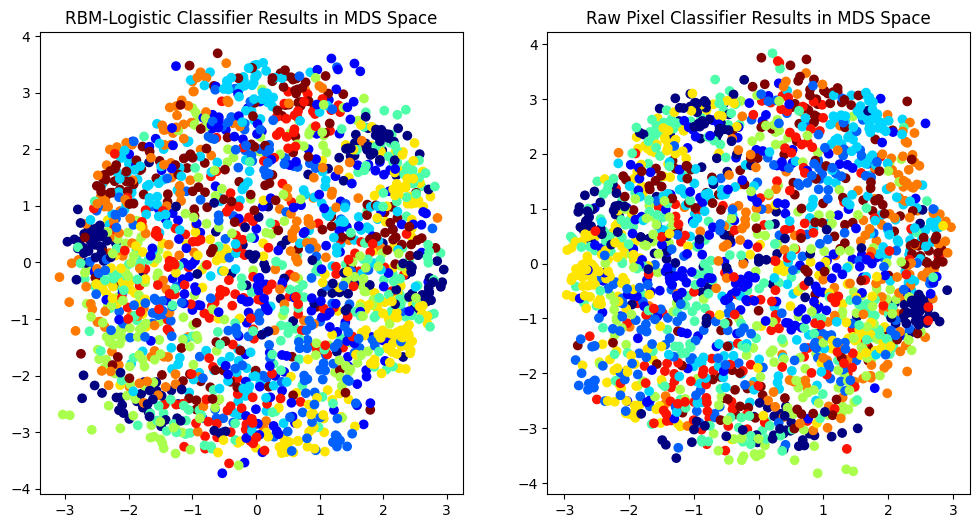

In [22]:
## MDS多维缩放
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings("ignore")

mds_rbm = MDS(n_components=2)
X_test_rbm_mds = mds_rbm.fit_transform(X_test)

mds_raw = MDS(n_components=2)
X_test_raw_mds = mds_raw.fit_transform(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test_rbm_mds[:, 0], X_test_rbm_mds[:, 1], c=Y_pred, cmap='jet')
plt.title('RBM-Logistic Classifier Results in MDS Space')
plt.subplot(1, 2, 2)
plt.scatter(X_test_raw_mds[:, 0], X_test_raw_mds[:, 1], c=Y_pred_, cmap='jet')
plt.title('Raw Pixel Classifier Results in MDS Space')
plt.savefig(fname="多维缩放可视化结果对比.png")

#### 4.2 RBM提取的150个组件

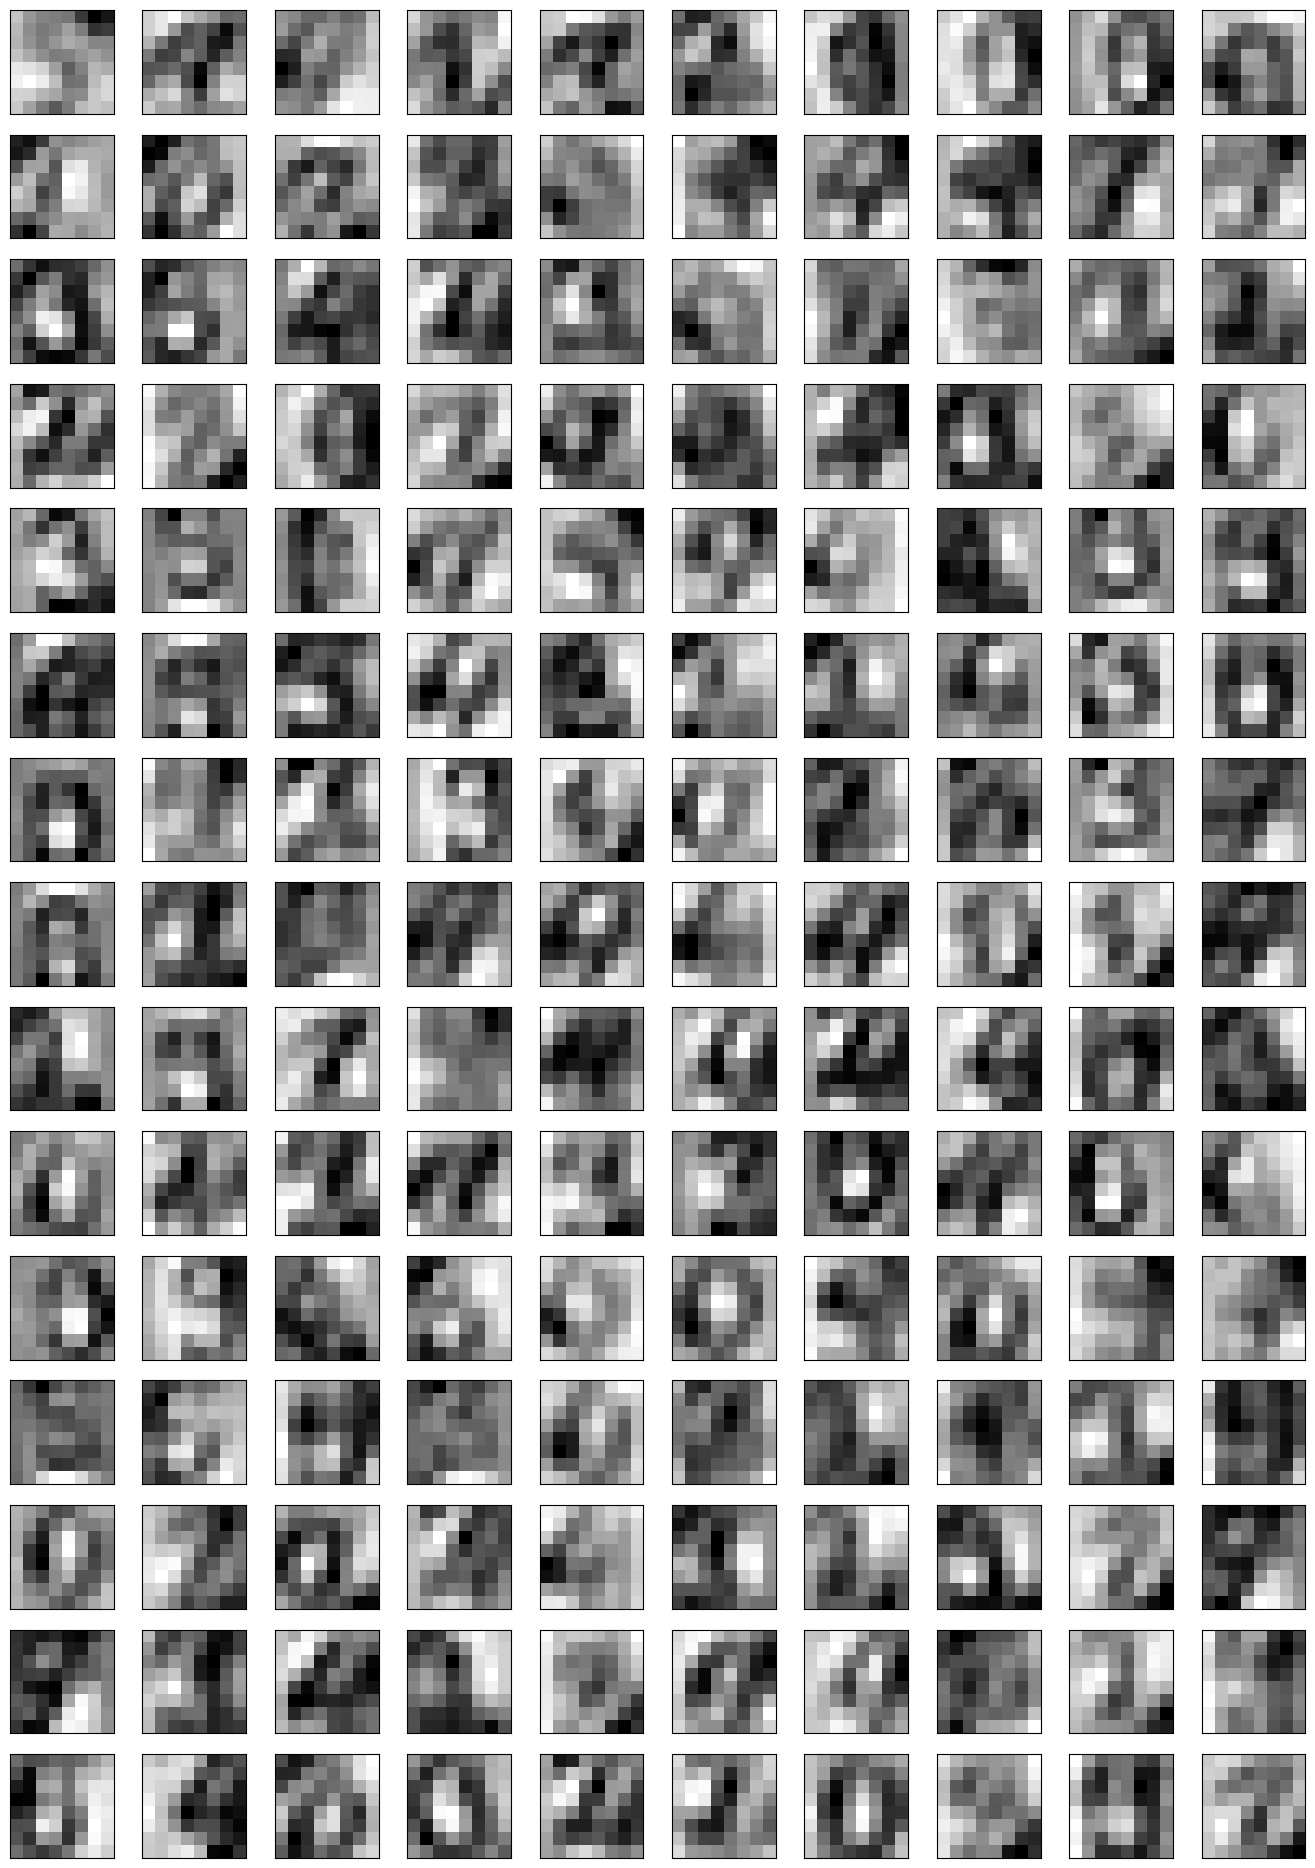

In [23]:
## 分类结果
plt.figure(figsize=(16.8, 24))
for i, comp in enumerate(rbm.components_):
    plt.subplot(15, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.savefig(fname="RBM提取的150个组件.png")

## 五、SOM自组织神经网络模型
### 5.1 粗调参
利用前面处理好的归一化后的数据，使用网格搜索寻找最佳参数，比较准则使用som提供的量化误差和拓扑误差

In [24]:
# --------------------------------6、SOM模型--------------------------------#
from minisom import MiniSom

## 定义SOM模型参数
som_shape = (10, 10)  ## 定义SOM网络的大小，手写数字0-9共10类，所以10*10
input_len = 64  ## 输入数据的维度（8x8图像展平后的维度）
sigma = 0.3  ## 初始化学习率 
num_iterations = 100  ## 训练的迭代次数

# 网格搜索最佳学习率
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

def grid_search_learning_rate(X, som_shape, input_len, sigma, num_iterations):
    best_learning_rate = None
    best_quantization_error = float('inf')
    best_topographic_error = float('inf')

    for learning_rate in learning_rates:
        som = MiniSom(som_shape[0], som_shape[1], input_len, sigma=sigma, learning_rate=learning_rate)
        som.random_weights_init(X)
        som.train_batch(X, num_iterations)

        quantization_error = som.quantization_error(X)
        topographic_error = som.topographic_error(X)

        print(f"学习率: {learning_rate}, 量化误差: {quantization_error}, 拓扑误差: {topographic_error}")

        if quantization_error < best_quantization_error and topographic_error < best_topographic_error:
            best_learning_rate = learning_rate
            best_quantization_error = quantization_error
            best_topographic_error = topographic_error

    return best_learning_rate, best_quantization_error, best_topographic_error

best_learning_rate, best_quantization_error, best_topographic_error = grid_search_learning_rate(X, som_shape, input_len, sigma, num_iterations)
print(f"最佳学习率: {best_learning_rate}, 最佳量化误差: {best_quantization_error}, 最佳拓扑误差: {best_topographic_error}")

学习率: 0.001, 量化误差: 1.8582504688332038, 拓扑误差: 0.9409015025041736
学习率: 0.005, 量化误差: 1.8673404494796773, 拓扑误差: 0.8714524207011686
学习率: 0.01, 量化误差: 1.8629694706939512, 拓扑误差: 0.9361157484696717
学习率: 0.05, 量化误差: 1.8236921416730911, 拓扑误差: 0.9439065108514191
学习率: 0.1, 量化误差: 1.8330584309935873, 拓扑误差: 0.9287701725097385
学习率: 0.5, 量化误差: 1.8114864695963946, 拓扑误差: 0.8974958263772955
学习率: 1, 量化误差: 1.8183485089299243, 拓扑误差: 0.9500278241513633
最佳学习率: 0.5, 最佳量化误差: 1.8114864695963946, 最佳拓扑误差: 0.8974958263772955


### 5.2 调参
根据粗调参结果进一步精细调参

In [26]:
## 定义SOM模型参数
som_shape = (10, 10)  ## 定义SOM网络的大小，手写数字0-9共10类，所以10*10
input_len = 64  ## 输入数据的维度（8x8图像展平后的维度）
sigma = 0.3  ## 初始化学习率 
num_iterations = 100  ## 训练的迭代次数

# 网格搜索最佳学习率
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def grid_search_learning_rate(X, som_shape, input_len, sigma, num_iterations):
    best_learning_rate = None
    best_quantization_error = float('inf')
    best_topographic_error = float('inf')

    for learning_rate in learning_rates:
        som = MiniSom(som_shape[0], som_shape[1], input_len, sigma=sigma, learning_rate=learning_rate)
        som.random_weights_init(X)
        som.train_batch(X, num_iterations)

        quantization_error = som.quantization_error(X)
        topographic_error = som.topographic_error(X)

        print(f"学习率: {learning_rate}, 量化误差: {quantization_error}, 拓扑误差: {topographic_error}")

        if quantization_error < best_quantization_error and topographic_error < best_topographic_error:
            best_learning_rate = learning_rate
            best_quantization_error = quantization_error
            best_topographic_error = topographic_error

    return best_learning_rate, best_quantization_error, best_topographic_error

best_learning_rate, best_quantization_error, best_topographic_error = grid_search_learning_rate(X, som_shape, input_len, sigma, num_iterations)
print(f"最佳学习率: {best_learning_rate}, 最佳量化误差: {best_quantization_error}, 最佳拓扑误差: {best_topographic_error}")

学习率: 0.1, 量化误差: 1.797756821263381, 拓扑误差: 0.9208681135225376
学习率: 0.2, 量化误差: 1.767174931622969, 拓扑误差: 0.9555926544240401
学习率: 0.3, 量化误差: 1.7816789708880247, 拓扑误差: 0.9056204785754034
学习率: 0.4, 量化误差: 1.7921936672790892, 拓扑误差: 0.9366722314969393
学习率: 0.5, 量化误差: 1.800253018242407, 拓扑误差: 0.940345019476906
学习率: 0.6, 量化误差: 1.8180527394842354, 拓扑误差: 0.9210907067334446
学习率: 0.7, 量化误差: 1.8130240099418267, 拓扑误差: 0.9176405119643851
学习率: 0.8, 量化误差: 1.8063966989840778, 拓扑误差: 0.8822481914301614
学习率: 0.9, 量化误差: 1.8166582119467058, 拓扑误差: 0.9098497495826378
学习率: 1, 量化误差: 1.8460761411085926, 拓扑误差: 0.8989426822481914
最佳学习率: 0.3, 最佳量化误差: 1.7816789708880247, 最佳拓扑误差: 0.9056204785754034


### 5.3 最佳参数训练模型

In [27]:
## 使用最佳学习率训练SOM模型
som = MiniSom(som_shape[0], som_shape[1], input_len, sigma=sigma, learning_rate=best_learning_rate)
som.random_weights_init(X)  ## 采用随机初始化权重
som.train_batch(X, num_iterations)

### 5.4 可视化权重

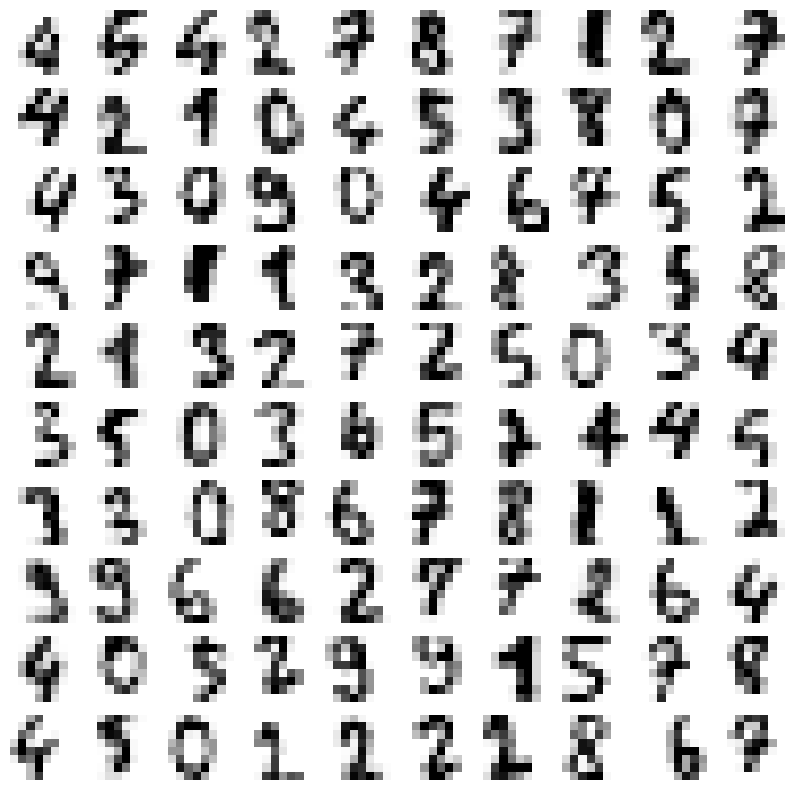

In [28]:
## 可视化SOM权重
plt.figure(figsize=(10, 10))
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        plt.subplot(som_shape[0], som_shape[1], i * som_shape[1] + j + 1)
        plt.imshow(som.get_weights()[i, j].reshape((8, 8)), cmap='Greys', interpolation='nearest')
        plt.axis('off')
plt.savefig(fname="SOM权重可视化.png")

### 5.5 映射数据到SOM并可视化
将数据映射到SOM上，得到每个数据点对应的最佳匹配单元（BMU）的坐标

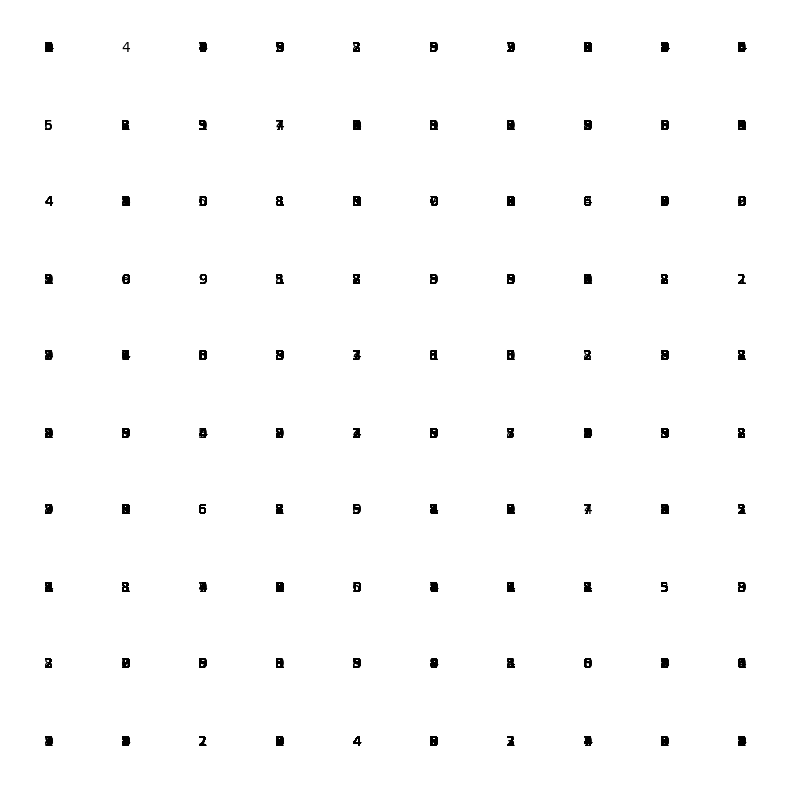

In [30]:
## 映射数据到SOM并可视化
# 将数据映射到SOM上，得到每个数据点对应的最佳匹配单元（BMU）的坐标
mapped = np.array([som.winner(x) for x in X])
plt.figure(figsize=(10, 10))
for i, m in enumerate(mapped):
    plt.text(m[0], m[1], str(Y[i]), color='black', ha='center', va='center')
plt.imshow(np.zeros(som_shape), cmap='Greys', interpolation='nearest')
plt.axis('off')
plt.savefig(fname="数据在SOM上的映射.png")